In [2]:
import pandas as pd
import numpy as np
from functools import reduce


In [3]:
def load_wb_indicator(path, value_name):
    df = pd.read_csv(path, skiprows=4)

    df = df.rename(columns={
        "Country Name": "country",
        "Country Code": "country_code"
    })

    year_cols = [c for c in df.columns if c.isdigit()]

    df = df[["country", "country_code"] + year_cols]

    df = df.melt(
        id_vars=["country", "country_code"],
        value_vars=year_cols,
        var_name="year",
        value_name=value_name
    )

    df["year"] = df["year"].astype(int)

    return df

In [4]:
dfs = [
    load_wb_indicator(
        "data/API_SP.DYN.LE00.IN_DS2_en_csv_v2_110210.csv",
        "life_expectancy"
    ),
    load_wb_indicator(
        "data/API_SH.DYN.MORT_DS2_en_csv_v2_110454.csv",
        "under5_mortality"
    ),
    load_wb_indicator(
        "data/API_SE.SEC.ENRR_DS2_en_csv_v2_110413.csv",
        "secondary_enroll"
    ),
    load_wb_indicator(
        "data/API_SE.TER.ENRR_DS2_en_csv_v2_110177.csv",
        "tertiary_enroll"
    ),
    load_wb_indicator(
        "data/API_NY.GNP.PCAP.PP.KD_DS2_en_csv_v2_117601.csv",
        "gni_ppp"
    ),
    load_wb_indicator(
        "data/API_EG.ELC.ACCS.ZS_DS2_en_csv_v2_110197.csv",
        "electricity"
    ),
]
dfs[3].head()

,country,country_code,year,tertiary_enroll
0,Aruba,ABW,1960,NaN
1,Africa Eastern and Southern,AFE,1960,NaN
2,Afghanistan,AFG,1960,NaN
3,Africa Western and Central,AFW,1960,NaN
4,Angola,AGO,1960,NaN


In [5]:
panel = reduce(
    lambda left, right: pd.merge(
        left,
        right,
        on=["country", "country_code", "year"],
        how="outer"
    ),
    dfs
)

panel = panel[
    (panel["year"] >= 2009) &
    (panel["year"] <= 2024)
]

panel.head()
panel.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4256 entries, 49 to 17289
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   country           4256 non-null   object 
 1   country_code      4256 non-null   object 
 2   year              4256 non-null   int64  
 3   life_expectancy   3975 non-null   float64
 4   under5_mortality  3660 non-null   float64
 5   secondary_enroll  2988 non-null   float64
 6   tertiary_enroll   2759 non-null   float64
 7   gni_ppp           2788 non-null   float64
 8   electricity       3945 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 332.5+ KB


In [6]:
import pycountry

iso3_countries = {c.alpha_3 for c in pycountry.countries}

In [7]:
panel = panel[panel["country_code"].isin(iso3_countries)]
panel.info()
panel.value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 3440 entries, 49 to 17289
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   country           3440 non-null   object 
 1   country_code      3440 non-null   object 
 2   year              3440 non-null   int64  
 3   life_expectancy   3225 non-null   float64
 4   under5_mortality  2925 non-null   float64
 5   secondary_enroll  2254 non-null   float64
 6   tertiary_enroll   2060 non-null   float64
 7   gni_ppp           2368 non-null   float64
 8   electricity       3210 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 268.8+ KB


country             country_code  year  life_expectancy  under5_mortality  secondary_enroll  tertiary_enroll  gni_ppp       electricity
Albania             ALB           2009  78.509           14.5              89.315720         32.923988        11365.575402  99.6           1
                                  2010  78.414           13.3              93.681824         43.327930        11675.348456  99.6           1
                                  2011  78.303           12.2              95.470528         49.399704        11937.178827  99.7           1
                                  2012  78.084           11.2              97.608612         58.621419        11990.586809  99.9           1
                                  2013  77.995           10.5              102.903210        63.844059        12491.290351  99.9           1
                                                                                                                                          ..
West Bank and Gaza

Видаляємо території по типу World чи інші незвичайні утворення з нашого датасету

Видаляємо країни де є багато пропусків

In [8]:
indicator_cols = panel.columns.difference(
    ["country", "country_code", "year"]
)

missing_share = (
    panel
    .groupby("country")[indicator_cols]
    .apply(lambda x: x.isna().mean().mean())
)

In [9]:
valid_countries = missing_share[missing_share <= 0.3].index
panel = panel[panel["country"].isin(valid_countries)]

In [10]:
panel.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2448 entries, 244 to 17289
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   country           2448 non-null   object 
 1   country_code      2448 non-null   object 
 2   year              2448 non-null   int64  
 3   life_expectancy   2295 non-null   float64
 4   under5_mortality  2265 non-null   float64
 5   secondary_enroll  1941 non-null   float64
 6   tertiary_enroll   1884 non-null   float64
 7   gni_ppp           2106 non-null   float64
 8   electricity       2295 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 191.2+ KB


Заповнюємо пропуски за допомогою лінійної інтерполяції (регресія)

In [11]:

panel[indicator_cols] = (
    panel
    .groupby("country")[indicator_cols]
    .transform(lambda x: x.interpolate(method="linear"))
)

panel[indicator_cols] = (
    panel
    .groupby("country")[indicator_cols]
    .transform(lambda x: x.bfill().ffill())
)
panel = panel.dropna()
panel.info()
panel.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2336 entries, 244 to 17289
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   country           2336 non-null   object 
 1   country_code      2336 non-null   object 
 2   year              2336 non-null   int64  
 3   life_expectancy   2336 non-null   float64
 4   under5_mortality  2336 non-null   float64
 5   secondary_enroll  2336 non-null   float64
 6   tertiary_enroll   2336 non-null   float64
 7   gni_ppp           2336 non-null   float64
 8   electricity       2336 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 182.5+ KB


,country,country_code,year,life_expectancy,under5_mortality,secondary_enroll,tertiary_enroll,gni_ppp,electricity
244,Albania,ALB,2009,78.509,14.5,89.315720,32.923988,11365.575402,99.6
245,Albania,ALB,2010,78.414,13.3,93.681824,43.327930,11675.348456,99.6
246,Albania,ALB,2011,78.303,12.2,95.470528,49.399704,11937.178827,99.7
247,Albania,ALB,2012,78.084,11.2,97.608612,58.621419,11990.586809,99.9
248,Albania,ALB,2013,77.995,10.5,102.903210,63.844059,12491.290351,99.9


Багатовимірний статистичний аналіз (будуємо кореляційну матрицю)

In [12]:
corr_matrix = panel[indicator_cols].corr()
corr_matrix


,electricity,gni_ppp,life_expectancy,secondary_enroll,tertiary_enroll,under5_mortality
electricity,1.000000,0.491448,0.808215,0.790421,0.634377,-0.840134
gni_ppp,0.491448,1.000000,0.723987,0.620449,0.573060,-0.548903
life_expectancy,0.808215,0.723987,1.000000,0.778266,0.713699,-0.893424
secondary_enroll,0.790421,0.620449,0.778266,1.000000,0.767469,-0.777461
tertiary_enroll,0.634377,0.573060,0.713699,0.767469,1.000000,-0.651241
under5_mortality,-0.840134,-0.548903,-0.893424,-0.777461,-0.651241,1.000000


Забув інвертувати показник смертності, бачимо високу від'ємну кореляцію між life_expectancy та under5_mortality, зробимо її додатньою

In [13]:
panel['under5_mortality'] = (
    panel['under5_mortality'].max() - panel['under5_mortality']
)

In [14]:
corr_matrix = panel[indicator_cols].corr()
corr_matrix

,electricity,gni_ppp,life_expectancy,secondary_enroll,tertiary_enroll,under5_mortality
electricity,1.000000,0.491448,0.808215,0.790421,0.634377,0.840134
gni_ppp,0.491448,1.000000,0.723987,0.620449,0.573060,0.548903
life_expectancy,0.808215,0.723987,1.000000,0.778266,0.713699,0.893424
secondary_enroll,0.790421,0.620449,0.778266,1.000000,0.767469,0.777461
tertiary_enroll,0.634377,0.573060,0.713699,0.767469,1.000000,0.651241
under5_mortality,0.840134,0.548903,0.893424,0.777461,0.651241,1.000000


In [15]:
panel = panel.rename(columns={
    'under5_mortality': 'under5_mortality_inv'
})


In [16]:
panel.to_csv('processed_data/filled_missed_data.csv', sep =';', index = False)

Нормалізуємо дані

In [17]:
from sklearn.preprocessing import StandardScaler

indicator_cols = panel.columns.difference(
    ["country", "country_code", "year"]
)

scaler = StandardScaler()

panel[indicator_cols] = scaler.fit_transform(panel[indicator_cols])

panel.head()


,country,country_code,year,life_expectancy,under5_mortality_inv,secondary_enroll,tertiary_enroll,gni_ppp,electricity
244,Albania,ALB,2009,0.710842,0.371963,0.139610,-0.378745,-0.586330,0.531497
245,Albania,ALB,2010,0.699040,0.409056,0.297520,-0.024545,-0.573467,0.531497
246,Albania,ALB,2011,0.685250,0.443057,0.362213,0.182168,-0.562595,0.535357
247,Albania,ALB,2012,0.658042,0.473967,0.439542,0.496119,-0.560377,0.543079
248,Albania,ALB,2013,0.646985,0.495605,0.631033,0.673923,-0.539586,0.543079


In [18]:
panel.to_csv('processed_data/normalized_indicators.csv', sep =';', index = False)

Будуємо композиційний індекс

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, kendalltau

In [20]:
indicator_cols = ['life_expectancy', 'under5_mortality_inv',
                  'secondary_enroll', 'tertiary_enroll',
                  'gni_ppp', 'electricity']
panel_pca = panel.copy()

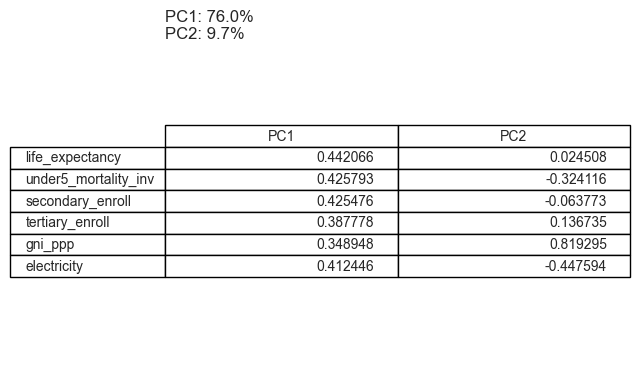

In [31]:
X_scaled = panel_pca[indicator_cols].values
pca = PCA(n_components=2)
pca.fit(X_scaled)

loadings = pd.DataFrame(
    pca.components_.T,
    index=indicator_cols,
    columns=['PC1', 'PC2']
)

explained = pca.explained_variance_ratio_
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 4))
ax.axis('off')

table = ax.table(
    cellText=loadings.round(6).values,
    rowLabels=loadings.index,
    colLabels=loadings.columns,
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.3)

title = (
    f"PC1: {explained[0]*100:.1f}%\n"
    f"PC2: {explained[1]*100:.1f}%"
)

plt.title(title, loc='left')
plt.show()

In [22]:
pca_weights = np.abs(pca.components_[0])
pca_weights_normalized = pca_weights / pca_weights.sum()
k = len(indicator_cols)
equal_weights = np.ones(k) / k

In [25]:
pca_scores = pca.transform(X_scaled)[:, 0]
print(pca_scores)
panel_pca['composite_pca'] = (pca_scores - pca_scores.min()) / (pca_scores.max() - pca_scores.min())
panel_pca['composite_equal'] = (X_scaled @ equal_weights)
panel_pca['composite_equal'] = ((panel_pca['composite_equal'] - panel_pca['composite_equal'].min()) /
                                 (panel_pca['composite_equal'].max() - panel_pca['composite_equal'].min()))

[ 0.3997659   0.61936835  0.74081935 ... -2.69787673 -2.46483919
 -2.46954141]


In [151]:
weights_df = pd.DataFrame({
    'Показник': indicator_cols,
    'PCA': pca_weights_normalized,
    '1/k': equal_weights,
    'Різниця': pca_weights_normalized - equal_weights,
    'Різниця %': ((pca_weights_normalized - equal_weights) / equal_weights) * 100
})
print(weights_df.to_string(index=False))

            Показник      PCA      1/k   Різниця  Різниця %
     life_expectancy 0.180989 0.166667  0.014322   8.593266
under5_mortality_inv 0.174326 0.166667  0.007659   4.595678
    secondary_enroll 0.174196 0.166667  0.007530   4.517814
     tertiary_enroll 0.158762 0.166667 -0.007905  -4.742721
             gni_ppp 0.142865 0.166667 -0.023802 -14.281160
         electricity 0.168862 0.166667  0.002195   1.317122


In [152]:
print(f"\n PC1: {pca.explained_variance_ratio_[0]:.4f} ({pca.explained_variance_ratio_[0]*100:.2f}%)")
print(f" PC1+PC2: {pca.explained_variance_ratio_[:2].sum():.4f} ({pca.explained_variance_ratio_[:2].sum()*100:.2f}%)")


 PC1: 0.7602 (76.02%)
 PC1+PC2: 0.8574 (85.74%)


Robustness / sensitivity analysis (виключаємо 1 індикатор та порівнюємо композитний індикатор)

In [155]:
jackknife_results = []
base_ranking = panel_pca[panel_pca['year'] == panel_pca['year'].max()].sort_values('composite_pca', ascending=False)['country'].values

for i, col in enumerate(indicator_cols):
    cols_subset = [c for c in indicator_cols if c != col]
    scaler_temp = StandardScaler()
    X_subset = scaler_temp.fit_transform(panel_pca[cols_subset])

    pca_temp = PCA(n_components=1)
    scores_normalized = pca_temp.fit_transform(X_subset).flatten()

    corr_pearson = np.corrcoef(panel_pca['composite_pca'], scores_normalized)[0, 1]
    corr_spearman, _ = spearmanr(panel_pca['composite_pca'], scores_normalized)

    latest_data = panel_pca[panel_pca['year'] == panel_pca['year'].max()].copy()
    latest_data['temp_index'] = scores_normalized[panel_pca['year'] == panel_pca['year'].max()]
    new_ranking = latest_data.sort_values('temp_index', ascending=False)['country'].values


    tau, _ = kendalltau([list(base_ranking).index(c) for c in new_ranking if c in base_ranking],
                        range(len(new_ranking)))

    jackknife_results.append({
        'Викл. індикатор': col,
        'Кор. Пірсона': corr_pearson,
        'Кор. Спірмена': corr_spearman,
        'Kendall Tau': tau,
        'Поясн. дисперсія PC1': pca_temp.explained_variance_ratio_[0]
    })

jackknife_df = pd.DataFrame(jackknife_results)
print(jackknife_df.to_string(index=False))

     Викл. індикатор  Кор. Пірсона  Кор. Спірмена  Kendall Tau  Поясн. дисперсія PC1
     life_expectancy      0.996215       0.993957     0.939348              0.739392
under5_mortality_inv      0.994437       0.998818     0.972981              0.754851
    secondary_enroll      0.994783       0.993234     0.933491              0.754873
     tertiary_enroll      0.992793       0.986927     0.913462              0.786267
             gni_ppp      0.992196       0.986440     0.922343              0.813646
         electricity      0.993513       0.999225     0.985640              0.766585


Бачимо високу кореляцію при видаленні ідникатора та незмінний відсоток поясненої дисперсії PC1

In [173]:
indicator_cols = ['life_expectancy', 'under5_mortality_inv',
                  'secondary_enroll', 'tertiary_enroll',
                  'gni_ppp', 'electricity']


panel_final = panel.copy()

# PCA
pca = PCA()
X = panel_final[indicator_cols].values
pca.fit(X)

# Ваги
weights = np.abs(pca.components_[0])
weights = weights / weights.sum()

# Індекс
panel_final['composite_index'] = (X @ weights)

# Нормалізація 0-1
panel_final['composite_index'] = (
    (panel_final['composite_index'] - panel_final['composite_index'].min()) /
    (panel_final['composite_index'].max() - panel_final['composite_index'].min())
)

result_df = panel_final[['country', 'country_code', 'year', 'composite_index']]
result_df = result_df.copy()
result_df['composite_index'] = result_df['composite_index'] * 100
result_df.to_csv('processed_data/composite_index.csv', sep =';', index = False)
top10_2024 = result_df[result_df['year'] == 2024].nlargest(10, 'composite_index')
top10_2024


,country,country_code,year,composite_index
11894,Norway,NOR,2024,99.681482
13844,Singapore,SGP,2024,98.353942
5329,Finland,FIN,2024,97.695376
7539,Ireland,IRL,2024,97.173344
909,Australia,AUS,2024,97.170575
5979,Greece,GRC,2024,96.918975
11309,Netherlands,NLD,2024,96.666794
1429,Belgium,BEL,2024,96.294874
15274,Sweden,SWE,2024,96.044069
3834,Denmark,DNK,2024,95.394555


In [174]:

from scipy.stats import spearmanr
panel_clean = result_df.copy()
equal_weights = np.ones(len(indicator_cols)) / len(indicator_cols)
panel_clean['index_equal'] = (X @ equal_weights)

panel_clean['index_equal'] = (
    (panel_clean['index_equal'] - panel_clean['index_equal'].min()) /
    (panel_clean['index_equal'].max() - panel_clean['index_equal'].min())
)

# Кореляція
corr_pearson = panel_clean['composite_index'].corr(panel_clean['index_equal'])
corr_spearman, _ = spearmanr(panel_clean['composite_index'], panel_clean['index_equal'])

print(f"Пірсон:  {corr_pearson:.4f}")
print(f"Спіарман: {corr_spearman:.4f}")

Пірсон:  0.9997
Спіарман: 0.9998
